In [1]:
# Author: Konstantin Kuchenmeister
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
from keras.models import Sequential
from keras.layers import Dense
from datetime import date, timedelta # Date Functions
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout

# 1. Read in and visualize data
For future work, the data pipeline could be automatised using the yahoo finance pkg yfinance (pip install yfinance).  
We are cutting away the first 5000 values, since this this time frame featured an insubtantial first and second moments. 
Empirically, I found that this holds the model back from modelling the steep increase throughout the last 3500 days.
Although the data shows clearly, that the moments depend on time t, for LSTM's it is not necessary to make the time series stationary.

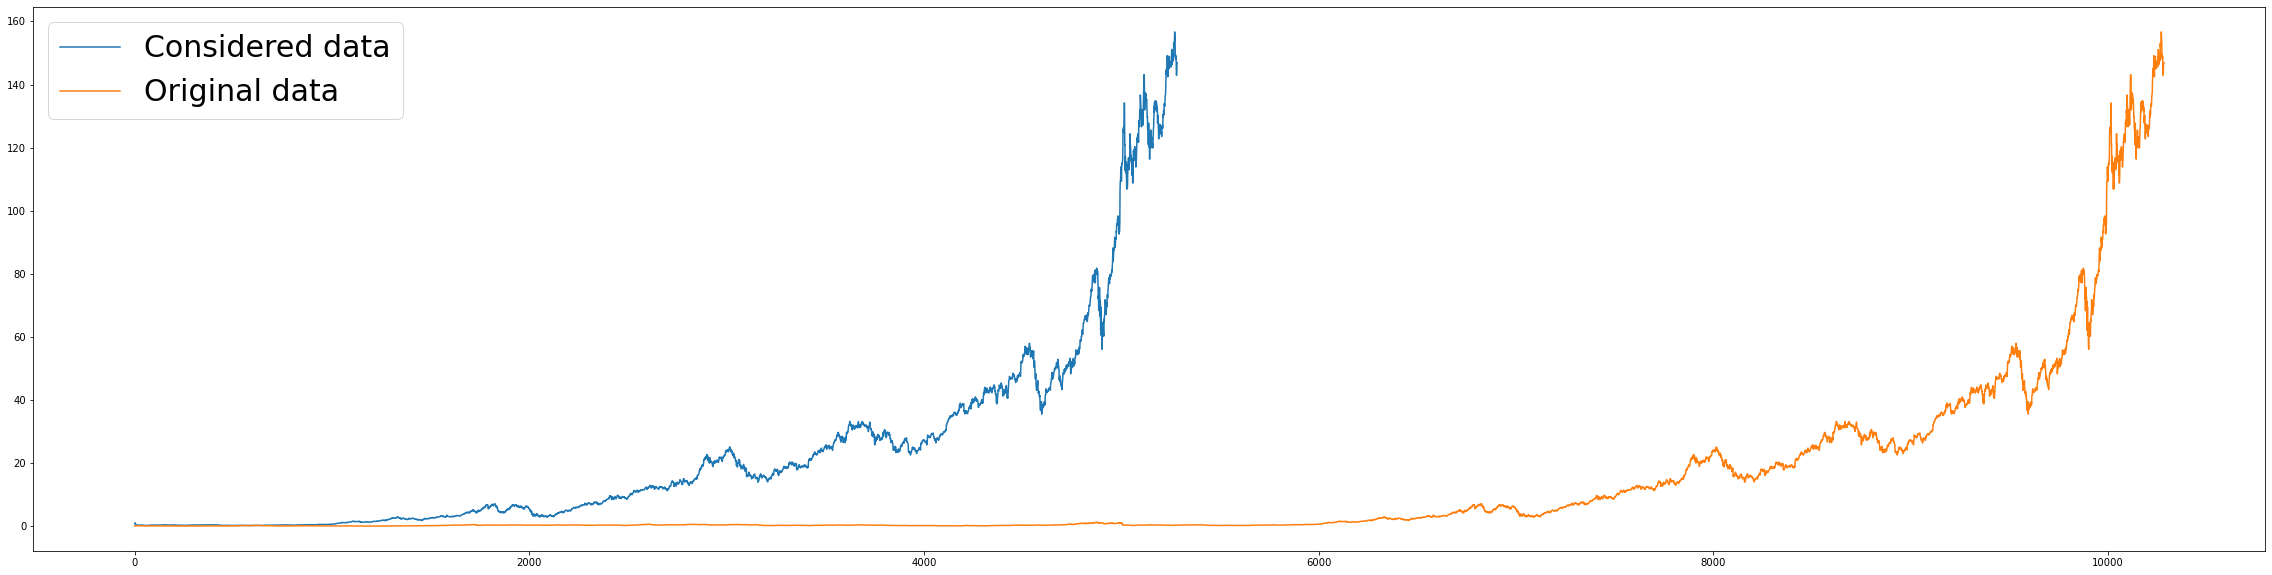

In [2]:
aapl = pd.read_csv('/Users/konstantinkuchenmeister/Downloads/aapl.csv')
#apple = aapl.iloc[:, 4:5].values
apple = aapl.iloc[5000:, 4:5].values
plt.figure(figsize=(40,10))
plt.plot(aapl.iloc[5000:, 4:5].values, label="Considered data")
plt.plot(aapl.iloc[:, 4:5].values, label="Original data")
plt.legend(loc="best", prop={'size': 30})
plt.show()

# 2. Exploring the data

In [3]:
# Converting the data we are working with back to a pandas dataframe so we can use the provided pandas functions
dfc = pd.DataFrame(aapl) 
print("Amount of NA-values: ", dfc.isna().sum())
dfc.head()

Amount of NA-values:  Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100600,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095352,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088353,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090540,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093165,73449600


In [4]:
# Returns summary statistics for the data set
dfc.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,1.028400e+04
mean,12.166066,12.294925,12.034579,12.169342,11.579424,3.350974e+08
std,25.525863,25.802606,25.240687,25.532322,25.234020,3.403352e+08
min,0.049665,0.049665,0.049107,0.049107,0.038490,0.000000e+00
25%,0.276919,0.284765,0.270508,0.277338,0.232861,1.270752e+08
50%,0.457589,0.464286,0.448661,0.457589,0.379018,2.231704e+08
75%,12.836071,12.866964,12.689197,12.792679,10.984002,4.171944e+08
max,156.979996,157.259995,154.389999,156.690002,156.690002,7.421641e+09


# 3. Commons
Methodology: make it as adaptable as possible.   
Therefore all steps are split up into functions that are delimited in nature.   


### 3.1 Scaling the data
Scaling the data into a range of (0,1).  
This is done for two reasons:  
    - We do not necessarily want to give higher value ranges higher weights       
    - Calculations tend to be less computationally expensive with smaller values     

In [5]:
def scaleData(series):
    """
    scaleData scales input data into a specified range using minmax-scaling

    :param series: a series of numerical values to be scaled
    :return: returns the scaled series
    """ 
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(series)
    print("Data was successfully scaled.")
    return scaled

### 3.2 Splitting the data 
After the data is scaled, we can split it into our training and test data.   
We train on the train data and train on the test data.
We will do a validation split automatically, later in the project.

In [6]:
def splitData(series, splitPercent=0.8):
    """
    splitData splits time series data into two partition dataset

    :param series: a series of numerical values to be split
    :param splitPercent: optional, the size of the test data compared to the total data in length, is 0.8 by default
                         the size of the test dataset is floored through integer casting
    :return: returns the train and test dataset
    """ 
    rowCount = len(series)
    trainSize = int(rowCount * splitPercent) # The trainsize is the floored length(data) * the split%
    train = series[:trainSize] # The training dataset is all data until the trainSize
    test = series[trainSize:] # The test dataset is all data from the trainSize
    print("Data was successfully split from " + str(rowCount) + " into ", end='')
    print("Train: " + str(len(train)), end=' ')
    print("Test: " + str(len(test)))
    return train, test

### 3.3 Preparing the data
After the data is split, it can needs to be prepared.  
This includes framing the problem.
We want to be able to predict the closing price at x<sub>t+1</sub> using the values (x<sub>t-n</sub>, x<sub>t</sub>), where n is the size of the sliding prediction window.          
In this formulation the values (x<sub>t-n</sub>, x<sub>t</sub>) are the feature, while x<sub>t+1</sub> is the label.     
This transformation is carried out using the prepareData mapping.

In [7]:
def prepareData(series, windowSize):
    """
    prepareData frames the time series into a machine learning problem
            features: (x_t-n, x_t) (for all t in [windowSize, length(series)])
            labels: x_t (for all t in data)

    :param series: a split and scaled series of data to be framed
    :param windowSize: the number of time steps (discrete days?) we look into the past to predict the future value
    :return: returns the features and the labels for the series that can be used for training
    """
    features = []
    labels = []
    for index in range(windowSize, len(series)): # (for all t in [windowSize, length(series)])
        features.append(series[index-windowSize:index, 0]) # (x_t-n, x_t)
        labels.append(series[index, 0]) # x_t
    features, labels = np.array(features), np.array(labels)
    return features, labels

### 3.4 Training the model
After the data has been scaled, split and prepared it is ready to be used for training.  
The model uses the features to make predictions which are then numerically compared to the labels using an cost function.   
We will use a Sequential model for analyzing the time series. We will add LSTM layers to the model that feature dropout layers to combat overfitting. The final layer will be a dense layer with just one unit, to retrieve a single output.
The model is trained with a parameterized number of epochs and batch size.

In [8]:
def lstmModel(tFeatures, tLabels, epochs, batchCount):
    """
    lstmModel creates and trains the model for a specified number of epochs and batch size.
    
    :param tFeatures: the scaled training features of the form (x_t-n, x_t)
    :param tLabels: the label data x_t
    :param epochs: the number of epochs
    :param tLabels: the batch size
    :return: returns model and its history based on a automatic validation split
    """ 
    model = Sequential() # Initiliazing the sequential model
    
    # Adding LSTM layers to the network, we will use a deep architecture will multiple layers,
    # since that has been shown to increase model performance due to the further level of abstraction
    # deep layers add
    model.add(LSTM(units = 500, return_sequences = False, input_shape=(tFeatures.shape[1], 1)))
    #model.add(Dropout(0.2)) # Combatting overfitting
    
    #model.add(LSTM(units = 60, return_sequences = True))
    #model.add(Dropout(0.2)) # Combatting overfitting
    
    #model.add(LSTM(units = 60, return_sequences = False))
    #model.add(Dropout(0.2)) # Combatting overfitting
    
    #model.add(LSTM(units = 10))
    
    #model.add(Dense(8, activation='relu'))
    
    model.add(Dense(units = 1)) # Final dense/output layer for single output
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
    history = model.fit(tFeatures, tLabels, validation_split = 0, epochs = epochs, batch_size = batchCount)
    return model, history

### 3.5 Inverting the scale of predictions
Since the model has learned based on scaled data, are the predictions on new data going to be on the scaled scale as well.
Therefore, the predictions can be inverted to the original scale.

In [9]:
def invertScale(forecasts, series):
    """
    invertScale is the inverse to splitData and reversing the scaling applied to a time series.
    
    :param forecasts: a series of scaled numerical prediction values to be reversed to original scale
    :param series: the actual series before it has been scaled
    :return: returns the inversely scaled series
    """ 
    scaler = MinMaxScaler(feature_range=(0, 1))
    scale = scaler.fit(series) # Fitting the scaler to the original data, to retrieve the original scale
    forecasts_scaled = scale.inverse_transform(forecasts) # Inversing the scaling
    return forecasts_scaled

### 3.6 Visualizing predictions for whole test set
After inverting the prediction we can visualize the predictions for single day prediction over the whole test dataset.

In [10]:
def visualizePredictions(testLength, predictions, windowSize):
    """
    visualizePredictions is a function for visualizing predictions against the real data during that time frame
    
    :param testLength: the length of the test dataset
    :param predictions: the inverted predictions
    :param windowSize: the size of the sliding feature window denoted with n (as before)
    """ 
    # Loding the original data
    trueData = pd.read_csv('/Users/konstantinkuchenmeister/Downloads/aapl.csv').iloc[-testLength:, 4:5].values
    plt.figure(figsize=(20,10))
    plt.plot(trueData, color='green', label='AAPL') # plotting the actual test data
    predictionX = list(range(windowSize, len(trueData))) # to account for last values not being considered due to out of bounds in preparedata
    plt.plot(predictionX, predictions, color='red', label='Predicted AAPL') # plotting the predictions
    # Misc
    plt.title('LSTM AAPL Single Day Prediction')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# 4. Recursive multi step prediction
In the following we are attempting to predict multiple time steps into the future.  
Let <i>f</i> denote the forecasting range, <i>t</i> the current time point, and <i>w</i> the window size.   
    For <i>i</i> in [0,<i>f</i>]:        
        1. Extract the last <i>t-w</i> values from the initial data and store it in <i>arr</i>   
        2. Pass <i>arr</i> to the model to predict the value at time <i>x<sub>t+1</sub></i>           
        3. Add this value to <i>arr</i>, and remove the value at <i>arr[0]</i>                        

In [11]:
# Single Week prediction using recursive strategy
# Recursive Multi-step Forecast
# https://machinelearningmastery.com/multi-step-time-series-forecasting/

def makeMultiStepPrediction(lBatch, forecastLength):
    # Shape has to be 1,windowSize,1
    lBatchReshaped = np.reshape(lBatch, (lBatch.shape[1], lBatch.shape[0], 1))
    
    # print(lBatchReshaped)

    lPrediction = model.predict(lBatchReshaped)

    windowX = list(lBatchReshaped[0]) # The window of length 7 that stores the current featureWindow
    results = list() # Storing the results

    for index in range(0, forecastLength):
        windowX.pop(0) # Drop the first observation of the sliding window
        windowX.append(lPrediction[0]) # Append the current prediction
    
        lBatchReshaped[0] = windowX # update the featureBatch
    
        fPrediction = model.predict(lBatchReshaped) # make the current prediction
    
        fPredictionScaled = invertScale(fPrediction, apple) # invert the prediction
        
        lPrediction[0] = fPrediction # for updating the windowX
        
        results.append(fPredictionScaled) # storing the result
    

    flattenedResults = list()
    for val in results:
        flattenedResults.append(val[0])
        
    return flattenedResults

In [12]:
def visualizePerformance(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.legend(loc='best')
    plt.show()

In [13]:
# timePoints: An array of timepoints that marks the last day of a windowsize-day batch that should be used for
# forecasting
def makeMultiMultiStepPrediction(timePoints, forecastLength):
    returnArr = np.zeros((len(timePoints),2, forecastLength))
    tmp = 0
    # 1. Check if the array of timepoints is valid
    for val in timePoints:
        if val <= len(test) and val > 50 :
            upper = -((len(test))-val)
            lower = -((len(test))-val)-50
            cBatch = np.array(data[lower:upper])
            multiStepResults = makeMultiStepPrediction(cBatch, forecastLength)
            multiStepX = np.arange(val, val+6)
            
            returnArr[tmp, 0, :] = multiStepX
            returnArr[tmp, 1, :] = multiStepResults
            
            tmp = tmp+1
        else:
            print("Timepoint %d is invalid" % (val))
        
    return returnArr

def visualizeMultiMultiStepPrediction(results):
    plt.figure(figsize=(30,15))
    for index in range(0, results.shape[0]):
        lower = results[index, 0, 0]
        upper = results[index, 0, results.shape[2]-1]
        label_ = ("Prediction period: %d - %d" % (lower, upper))
        plt.plot(results[index, 0, :], results[index, 1, :], label = label_, color = "red")
        plt.legend(loc="best", prop={'size': 30})
    trueData = pd.read_csv('/Users/konstantinkuchenmeister/Downloads/aapl.csv').iloc[-len(test):, 4:5].values
    plt.plot(trueData, color="green")
    plt.legend(loc="best")
    plt.show()

Data was successfully scaled.
Data was successfully split from 5284 into Train: 4491 Test: 793
[[4.60878655e-03 4.37338448e-03 4.08804495e-03 ... 3.85776893e-04
  4.49980364e-04 4.07175919e-04]
 [4.37338448e-03 4.08804495e-03 4.60878655e-03 ... 4.49980364e-04
  4.07175919e-04 4.42840963e-04]
 [4.08804495e-03 4.60878655e-03 1.44152611e-03 ... 4.07175919e-04
  4.42840963e-04 1.36102410e-04]
 ...
 [2.97293165e-01 2.96206583e-01 2.98315819e-01 ... 3.09804699e-01
  3.08829982e-01 3.03668758e-01]
 [2.96206583e-01 2.98315819e-01 2.97564807e-01 ... 3.08829982e-01
  3.03668758e-01 3.01959022e-01]
 [2.98315819e-01 2.97564807e-01 2.99482277e-01 ... 3.03668758e-01
  3.01959022e-01 3.02566203e-01]]
[4.42840963e-04 1.36102410e-04 1.36102410e-04 ... 3.01959022e-01
 3.02566203e-01 3.20478633e-01]
(4441, 50, 1)
89/89 [==============================] - 15s 153ms/step - loss: 3.8077e-04 - accuracy: 2.2517e-04


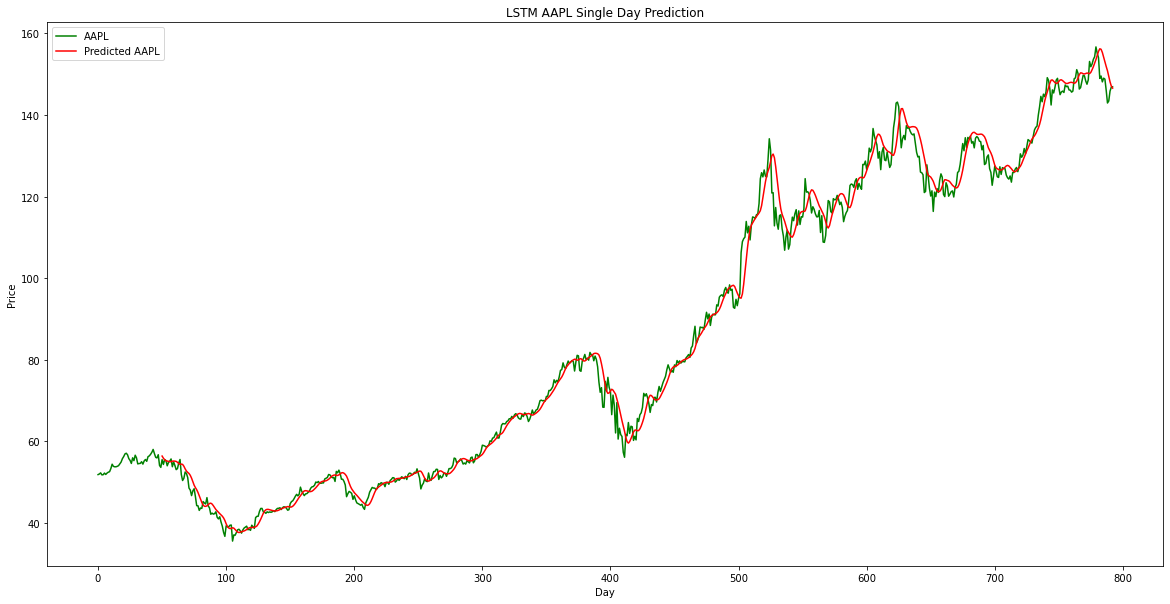

In [14]:
# Single day prediction
data = scaleData(apple)

splitPercentage = .85

train, test = splitData(data, splitPercentage)

windowSize = 50
trainFeatures, trainLabels = prepareData(train, windowSize)
testFeatures, testLabels = prepareData(test, windowSize)

print(trainFeatures)
print(trainLabels)

features = np.reshape(trainFeatures, (trainFeatures.shape[0], trainFeatures.shape[1], 1))

print(features.shape) # (rows, columns, step)

model, history = lstmModel(features, trainLabels, 1, 50)
testFeatures = np.reshape(testFeatures, (testFeatures.shape[0], testFeatures.shape[1], 1))
predictions = model.predict(testFeatures)

predictions = invertScale(predictions, apple)

visualizePredictions(len(test), predictions, windowSize)

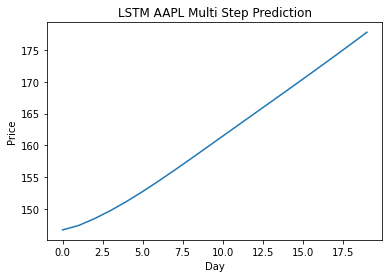

In [15]:
# The multistep prediction for the last date of the data + 20

lBatch = np.array(data[-50:])

multiStepResults = makeMultiStepPrediction(lBatch, 20)

plt.plot(multiStepResults, label = 'Predicted')
plt.title('LSTM AAPL Multi Step Prediction')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

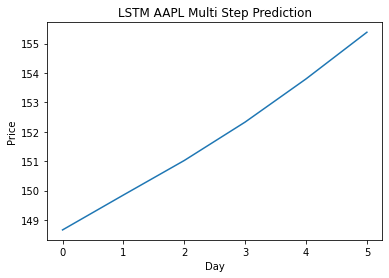

In [16]:
# The multistep prediction for the last date of the data + 6

lBatch = np.array(data[-100:-50])
multiStepResults = makeMultiStepPrediction(lBatch, 6)

plt.plot(multiStepResults, label = 'Predicted')
plt.title('LSTM AAPL Multi Step Prediction')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

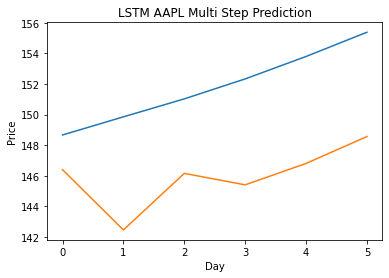

In [17]:
# In order to be able to compare our multi-step prediction results, we attempt to predict the following:
# Let x denote the index of the last day of the dataset
# Take the window [x - 100, x - 50] to predict the values [x-50+1, x-50+5].
# We are basically shifting our unknown state of the world back in time, pretending these observations have not yet
# happened.
# This allows us, to compare our multistep prediction of [x-50+1, x-50+5] to the actual [x-50+1, x-50+5] data.

lBatch = np.array(data[-100:-50])

multiStepResults = makeMultiStepPrediction(lBatch, 6)

actualResults = invertScale(np.array(data[-50:-44]), apple)

plt.plot(multiStepResults, label="Predicted values")
plt.plot(actualResults, label="Original data")
plt.title('LSTM AAPL Multi Step Prediction')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

In [18]:
lBatch = np.array(data[-100:-50])

lBatchReshaped = np.reshape(lBatch, (lBatch.shape[1], lBatch.shape[0], 1))

print(lBatchReshaped.shape)

predict = model.predict(lBatchReshaped)

predict = invertScale(predict, apple)
print(predict)

(1, 50, 1)
[[147.77531]]


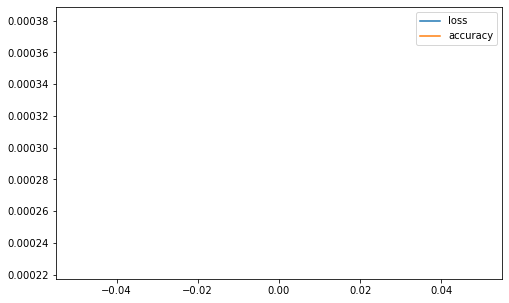

In [19]:
visualizePerformance(history)

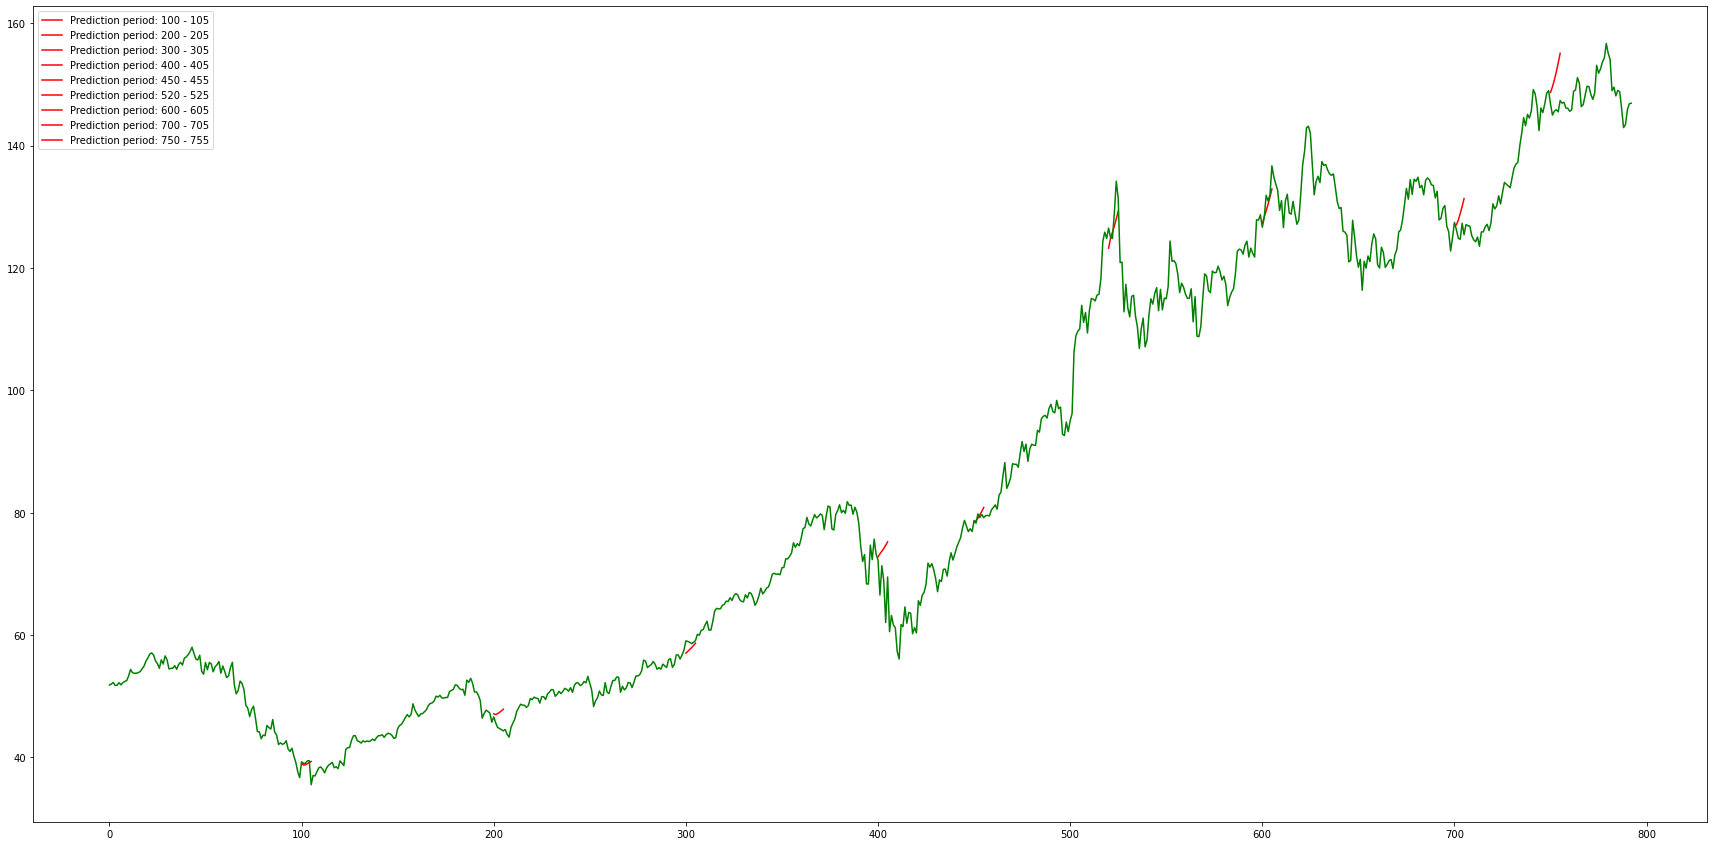

In [20]:
res = makeMultiMultiStepPrediction([100, 200, 300, 400, 450, 520, 600, 700, 750],6)
visualizeMultiMultiStepPrediction(res)

Data was successfully scaled.


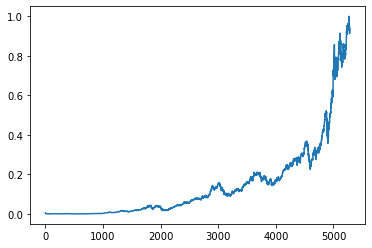

In [21]:
data = scaleData(apple)
plt.plot(data)